# SemEval 2021 Task 5: Toxic Spans Detection

### Research & Development

In [58]:
import csv
import os
import random
from ast import literal_eval
from itertools import groupby
from operator import itemgetter

import numpy as np
import pandas as pd
import torch
from plotnine import *
from pytorch_lightning import (
    LightningModule,
    LightningDataModule,
    Trainer,
    seed_everything,
)
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils import data
from tqdm import tqdm
from transformers import MobileBertTokenizerFast, MobileBertForTokenClassification


pd.set_option("display.max_colwidth", None)
random.seed(a=42)

In [2]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [3]:
PROJECT_ROOT = os.getcwd().split("toxic-spans-detection")[0] + "toxic-spans-detection"

## Table of Contents

- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [A First Baseline](#A-First-Baseline)
- [As a Downstream Task](#As-a-Downstream-Task)

Our [objective](https://competitions.codalab.org/competitions/25623#learn_the_details-overview) here is to train a suitable model that will be able to predict the toxic spans -if any- contained in new, unseen documents.

We will treat this as a binary sequence labelling task.

## Exploratory Data Analysis

In [4]:
DATA_DIR = os.path.join(PROJECT_ROOT, "data")

trainset = pd.read_csv(os.path.join(DATA_DIR, "tsd_train.csv"))

inspect_df(trainset)

shape: (7939, 2)


,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]",Another violent and aggressive immigrant killing a innocent and intelligent US Citizen.... Sarcasm
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junior pal. What you are saying makes no sense. I don't know what you are basing this on. The cheap black market crap is still coming up from Mexican nationals, and the good stuff from BC and Humbolt. The I5 corridor is still just as busy, and they are still making a ton of money. Nothing has really changed except that the legal market has made it easy for anyone of legal age to buy it. And the legal market is controlled by corporate growers with million dollar facilities, or a co-op of smaller growers. The Federal government ""war on drugs"" really has no impact on the legal market in Oregon. I don't see any glutton of weed, whatever that means."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know this would be offensive??
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nAnyone and everyone. This is a community problem, so everyone who wants to be part of the solution should be allowed to help. As I said above: remove all protections on free ranging cats, and allow people to help. People who allow their pets to roam outside are part of the problem, because their pets are part of the problem. It would be very sad if pets were killed, but ultimately it is the owner's responsibility to make sure their pets are not out killing birds.\n\nYears ago some Vermont acquaintances got one warning from the Ranger: Next time I see your dog running deer, I'll shoot it. Next time she saw it running deer, she did. \n\nVermont does not pretend that trapping, neutering, and releasing dogs solves any problems. They are serious about threats. We just want to feel good about ourselves. If we were serious about feral cats, we would kill them. Neutered cats eat birds. Don't release them. Kill them."


In [5]:
def deserialize_spans(spans: pd.Series) -> pd.Series:

    try:
        return spans.apply(literal_eval)

    except ValueError as exc:  # in case cell is executed more than once
        print(str(exc))
        return spans

In [6]:
# we will deserialize spans from strings to proper objects (lists)
trainset["spans"] = deserialize_spans(trainset["spans"])

In [7]:
# how many data points contain toxic spans?
toxic = trainset["spans"].apply(len) > 0

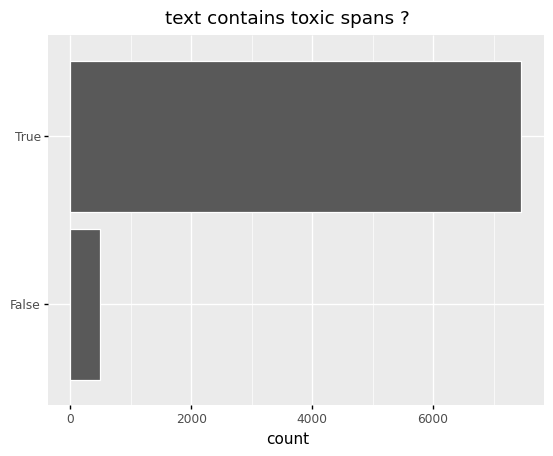

<ggplot: (8739866165017)>

In [8]:
(
    ggplot()
    + geom_bar(mapping=aes(x=toxic), colour="white")
    + labs(title="text contains toxic spans ?", x="")
    + coord_flip()
)

In [9]:
# some non-toxic documents
inspect_df(trainset[~toxic])

shape: (485, 2)


,spans,text
5,[],"But, but, but, is NOT a defense. It's not even a good deflection. In America today we have Nazis waving the Nazi flag at rallies in our cities. In what capacity does anyone think this is ok and who would not see that as a problem?\n\nEnough with the ""Well what about blah blah"" garbage."
21,[],"Jim\n\nI think Donald is a con man and a dangerous, narcissistic buffoon. But I don't hate Donald. He's not worth the emotional effort needed to hate. To say I hate him is to admit that I even care about him, which I don't. What I do care about is the damage he's already caused to this country, and the continuing damage he'll cause to this country and the world until he leaves office."
24,[],Exposing hypocrites like Trump and Pence is therapeutic for you? Good job!
27,[],"The malignant narcissist, mentally deranged sociopath, bigot, rascist, disingenuous blowhard and pathological liar, has now certified himself as a fascist. How much longer before his GOP sycophants and suckees say, ""Enough!"", and demand this repugnant, excrement-spewing fool's ouster?"
60,[],"the is NO CONSENSUS you ignorant loser, NONE, nothing but debate, thousands of scientist do not agree period, we dont need to move from anything other than left wing stupidity like yours."


We can observe that, although these `485` texts do not have toxic spans as annotation, some of them clearly contain toxic words, phrases etc.

In [10]:
trainset["text"].map(len).describe()

count    7939.000000
mean      204.570601
std       201.369223
min         4.000000
25%        72.000000
50%       136.000000
75%       262.000000
max      1000.000000
Name: text, dtype: float64

The average document in the training dataset has `204` characters, the shortest one is only `4` characters while the largest one is `1000`. 

In [11]:
trainset[toxic]["spans"].map(len).describe()

count    7454.000000
mean       18.663134
std        46.955908
min         2.000000
25%         6.000000
50%         9.000000
75%        16.000000
max       994.000000
Name: spans, dtype: float64

The average toxic document in the training dataset has `~19` toxic characters (i.e. characters belonging to toxic character sequences).

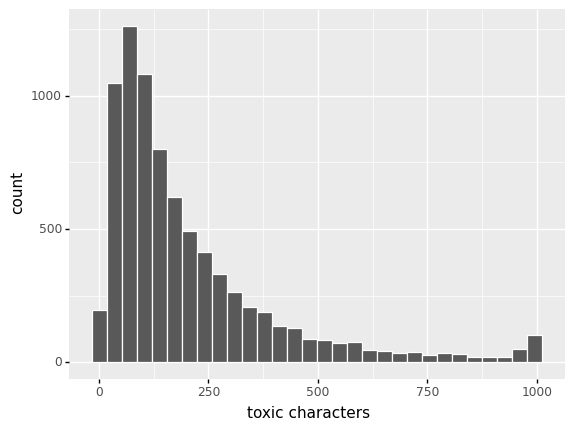

<ggplot: (8739866138868)>

In [12]:
(
    ggplot()
    + geom_histogram(mapping=aes(x=trainset["text"].map(len)), colour="white", bins=30)
    + xlab("toxic characters")
)

We can observe that in a typical span, let's say:

$$ [ 3, 4, 5, 6, 44, 45, 46 ] $$

groups of consequtive integers ($ 3 \rightarrow 6, 44 \rightarrow 46$) are basically individual character sequences.

Based on that observation, we can also get a peek on the number of toxic character sequences in the training dataset.

In [13]:
def continuous_spans(iterable: list):
    """Yield groups of continuous spans from an `iterable`.

    Example:

        iterable: [10, 11, 12, 13, 14, 15, 51, 52, 53, 54, 55, 56]

        Returns: an iterator of groups. Each group is itself an iterator that materializes in a continuous span:
                     1. [10, 11, 12, 13, 14, 15]
                     2. [51, 52, 53, 54, 55, 56]

    Inspired by: https://more-itertools.readthedocs.io/en/stable/api.html#more_itertools.consecutive_groups
    """
    for _, g in groupby(enumerate(iterable), key=lambda x: x[0] - x[1]):
        yield map(itemgetter(1), g)

In [14]:
charsequences = trainset[toxic]["spans"].apply(
    lambda s: [list(charseq) for charseq in continuous_spans(s)]
)

In [15]:
charsequences.map(len).describe()

count    7454.000000
mean        1.381540
std         0.791483
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        25.000000
Name: spans, dtype: float64

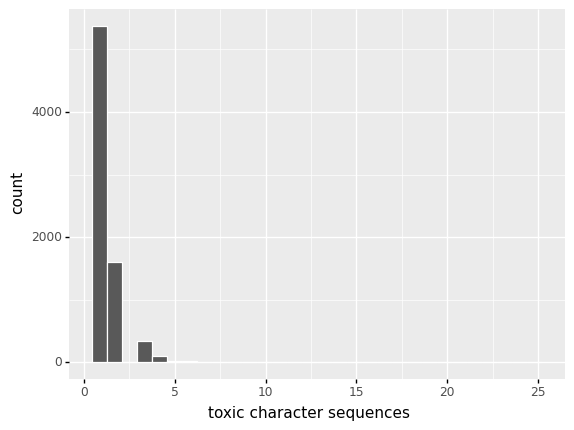

<ggplot: (8739866113238)>

In [16]:
(
    ggplot()
    + geom_histogram(mapping=aes(x=charsequences.map(len)), colour="white", bins=30)
    + xlab("toxic character sequences")
)

So, a typical toxic document of the training dataset is likely to have 1 or 2 character sequences that attribute to its toxicity.

## A First Baseline

We will establish an $ F_1 $ score, suitable for the representations of this task.

In [17]:
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).

        >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714

    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1

    Originally in: https://github.com/ipavlopoulos/toxic_spans/blob/master/evaluation/semeval2021.py
    """
    if len(gold) == 0:
        return 1.0 if len(predictions) == 0 else 0.0

    if len(predictions) == 0:
        return 0.0

    predictions_set = set(predictions)
    gold_set = set(gold)

    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)

    return float(nom) / float(denom)

To better understand the complexity of this task, we will create a basic random sequence labeller and assess its performance.

In [18]:
class RandomSequenceLabeller(object):
    """Random sequence labeller - returns toxic offsets at random."""

    def predict(self, doc: str) -> list:

        return [i for i, ch in enumerate(doc) if random.random() > 0.5]

In [19]:
# fetch the validation set
validationset = pd.read_csv(os.path.join(DATA_DIR, "tsd_trial.csv"))

validationset["text"] = validationset["text"].apply(str.lower)
validationset["spans"] = deserialize_spans(validationset["spans"])

Let us isolate a document of the validation set, for demonstration purposes.

In [20]:
validationset["text"].loc[11]

'trump said, in as many words, that mexicans were rapists and drug dealers.'

In [21]:
random_model = RandomSequenceLabeller()

pred = random_model.predict(doc=validationset["text"].loc[11])

In [22]:
print(validationset["text"].loc[11])
print("-" * 100)
print(str(pred))

trump said, in as many words, that mexicans were rapists and drug dealers.
----------------------------------------------------------------------------------------------------
[0, 4, 5, 6, 11, 14, 15, 17, 18, 20, 21, 24, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 48, 53, 54, 55, 57, 60, 61, 62, 63, 64, 65, 71, 72]


In [23]:
f1(pred, gold=validationset["spans"].loc[11])

0.5

In [24]:
# and now for the whole validation dataset
valset = validationset.copy()

valset["random_predictions"] = valset["text"].apply(random_model.predict)
valset["f1_score"] = valset.apply(
    lambda s: f1(s.random_predictions, gold=s.spans), axis=1
)

inspect_df(valset)

shape: (690, 4)


,spans,text,random_predictions,f1_score
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",because he's a moron and a bigot. it's not any more complicated than that.,"[0, 2, 6, 8, 9, 12, 13, 17, 18, 22, 23, 24, 25, 27, 28, 29, 31, 35, 36, 38, 40, 41, 43, 44, 46, 47, 48, 49, 53, 54, 55, 58, 59, 63, 64, 67, 69, 72, 73]",0.244898
1,"[29, 30, 31, 32, 33, 34]",how about we stop protecting idiots and let nature add some bleach to the gene pool. we can always submit their names for the darwin awards.,"[2, 3, 5, 9, 13, 15, 16, 19, 22, 23, 25, 26, 32, 33, 34, 38, 45, 47, 48, 50, 51, 52, 53, 54, 61, 63, 66, 67, 68, 69, 72, 73, 74, 75, 77, 78, 79, 81, 84, 85, 88, 90, 91, 93, 94, 95, 97, 100, 103, 106, 107, 111, 112, 113, 116, 117, 118, 119, 120, 122, 124, 125, 129, 131, 132, 134, 137, 138]",0.081081
2,"[166, 167, 168, 169, 170, 171]","if people were smart, they would boycott this inept airline, but they are not smart, so rogue businesses like this one, still thrive taking the idiots for a ride...","[3, 4, 6, 7, 11, 12, 13, 14, 15, 19, 20, 21, 22, 26, 27, 29, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 44, 46, 47, 49, 52, 57, 58, 60, 62, 63, 64, 66, 68, 72, 74, 75, 77, 79, 81, 82, 83, 84, 85, 88, 91, 92, 100, 101, 102, 103, 105, 109, 110, 115, 116, 119, 120, 122, 123, 124, 130, 133, 135, 138, 140, 141, 145, 146, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 167, 168, 169, 170, 176, 179, 180, 183, 187]",0.077670
3,"[87, 88, 89, 90, 91, 92]","trump claimed that russia will never invade the ukraine, when russia already has - how stupid can people be?","[0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 19, 24, 27, 29, 36, 38, 39, 43, 44, 46, 47, 48, 49, 50, 55, 56, 58, 59, 61, 62, 64, 65, 69, 70, 72, 74, 75, 77, 78, 79, 81, 82, 86, 88, 89, 91, 92, 93, 94, 96, 97, 99, 100, 103, 105, 106]",0.129032
4,[],"as long as your willing to pay a lot more for products you buy, then fine.\nbut you better not be going to costco and walmart to buy stuff because it's cheaper.\nif so, we get to call you a hypocritical wanker.","[0, 3, 6, 9, 11, 12, 15, 17, 19, 20, 21, 23, 26, 28, 30, 32, 34, 40, 41, 45, 46, 47, 54, 56, 57, 58, 60, 62, 63, 68, 70, 73, 76, 78, 80, 81, 82, 84, 87, 88, 90, 91, 92, 93, 96, 102, 105, 106, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 122, 123, 126, 127, 128, 129, 137, 138, 139, 140, 141, 142, 145, 147, 148, 150, 151, 156, 157, 159, 161, 162, 163, 167, 169, 170, 171, 172, 176, 177, 178, 180, 181, 183, 185, 186, 189, 190, 192, 193, 196, 198, ...]",0.000000


In [25]:
valset["f1_score"].mean()

0.1798930647084133

So, averaging over the validation dataset, our random classifier achieves an F1 score of approx. `17%`.

We consider this a baseline performance for this task. Let's improve on this.

## As a Downstream Task

We will begin with some pre-trained model, that can be fine-tuned to our task,to develop a better feel for the problem.

We will utilize a [transformer](https://huggingface.co/google/mobilebert-uncased) MobileBERT model and its respective tokenizer for preprocessing.

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [27]:
class ToxicSpansDataset(data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        row = self.data.iloc[idx]

        return {
            "tokens": torch.tensor(row["pad_tokenized_text"]).long(),
            "attention_mask": torch.tensor(row["pad_attention_mask"]).long(),
            "labels": torch.tensor(row["pad_encoded_span"]).long(),
            "pad_offset_mapping": torch.tensor(row["pad_offset_mapping"]).long(),
            "pad_span": torch.tensor(row["pad_raw_spans"]).long(),
        }

In [28]:
class ToxicSpansDataModule(LightningDataModule):
    def __init__(self, tokenizer, batch_size: int = 32, max_len: int = 512):

        super().__init__()

        self.data_dir = os.path.join(PROJECT_ROOT, "data")
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_len
        self.trainset = None
        self.validationset = None

    def prepare_data(self, *args, **kwargs) -> None:

        # load data into memory
        trainset = pd.read_csv(os.path.join(self.data_dir, "tsd_train.csv"))
        validationset = pd.read_csv(os.path.join(self.data_dir, "tsd_trial.csv"))

        # preprocessing
        self.trainset = self._preprocess(trainset)
        self.validationset = self._preprocess(validationset)

    def _preprocess(self, df: pd.DataFrame) -> pd.DataFrame:

        df["spans"] = deserialize_spans(df["spans"])

        docs, spans = df["text"].values, df["spans"]

        data = []
        for sentence, span in tqdm(zip(docs, spans), total=len(docs)):

            encoded = self.tokenizer(
                sentence,
                add_special_tokens=True,
                padding="max_length",
                return_offsets_mapping=True,
                max_length=self.max_length,
            )

            encoded_span = np.array(
                [
                    1 if any((left <= chr_pos < right for chr_pos in span)) else 0
                    for left, right in encoded["offset_mapping"]
                ]
            )

            tokens = np.array(encoded.encodings[0].tokens)

            padded_span = np.pad(
                span,
                mode="constant",
                pad_width=(0, 1024 - len(span)),
                constant_values=-1,
            )

            data.append(
                [
                    sentence,
                    span,
                    padded_span,
                    encoded["input_ids"],
                    encoded["attention_mask"],
                    encoded["offset_mapping"],
                    encoded_span,
                    tokens,
                ]
            )

        return pd.DataFrame(
            data,
            columns=[
                "raw_text",
                "raw_spans",
                "pad_raw_spans",
                "pad_tokenized_text",
                "pad_attention_mask",
                "pad_offset_mapping",
                "pad_encoded_span",
                "pad_tokens",
            ],
        )

    def train_dataloader(self) -> data.DataLoader:

        return data.DataLoader(
            ToxicSpansDataset(self.trainset), num_workers=8, batch_size=self.batch_size
        )

    def val_dataloader(self) -> data.DataLoader:

        return data.DataLoader(
            ToxicSpansDataset(self.validationset),
            num_workers=8,
            batch_size=self.batch_size,
        )

In [29]:
def split_sentence(tokenizer, text: str, max_sentence_length: int, spans=None) -> tuple:

    encoded = tokenizer(text, add_special_tokens=True, return_offsets_mapping=True)

    sentences_offsets = [
        offset[1]
        for input_ids, offset in zip(encoded["input_ids"], encoded["offset_mapping"])
        if input_ids == 1012
    ]

    if len(sentences_offsets) == 0 or len(text) - sentences_offsets[-1] > 0:
        sentences_offsets.append(len(text))

    new_split = [0]
    for split_offset_id in range(len(sentences_offsets) - 1):
        if sentences_offsets[split_offset_id + 1] - new_split[-1] > max_sentence_length:
            new_split.append(sentences_offsets[split_offset_id])

    if not new_split[-1] == sentences_offsets[-1]:
        new_split.append(sentences_offsets[-1])

    if spans:
        spans_vector = [i in row["spans"] for i in range(len(row["text"]))]

    texts, new_spans, offsets = [], [], []
    for offset_id in range(len(new_split) - 1):
        a, b = new_split[offset_id], new_split[offset_id + 1]
        texts.append(text[a:b])
        offsets.append(new_split[offset_id])

        if spans:
            spans_in_subtext = [
                idx for idx, is_true in enumerate(spans_vector[a:b]) if is_true
            ]
            new_spans.append(spans_in_subtext)

    if not spans:
        new_spans = [[] for _ in range(len(offsets))]

    return texts, offsets, new_spans

In [56]:
class ToxicSpansModule(LightningModule):
    def __init__(self, model=None, *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.model = model

    def forward(self, *args, **kwargs):
        """Use for inference only."""
        pred = self.model(*args, **kwargs)

        return pred

    def training_step(self, batch, batch_nb) -> dict:
        """The full training loop."""
        outputs = self(
            batch["tokens"],
            token_type_ids=None,
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )

        loss = outputs.loss
        self.log("train_loss", loss.item(), logger=True, on_step=False, on_epoch=True)

        return {"loss": loss}

    def validation_step(self, batch, batch_nb) -> None:
        """The full validation loop."""
        outputs = self(
            batch["tokens"],
            token_type_ids=None,
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )

        loss = outputs.loss
        self.log("val_loss", loss.item(), logger=True, on_step=False, on_epoch=True)

        logits = outputs.logits.detach().cpu().numpy()

        # get predictions from logits
        y_pred = np.argmax(logits, axis=-1).astype(int)
        # also fetch ground truth
        y_true = batch["labels"].to("cpu").numpy().astype(int)

        pad_span = batch["pad_span"].to("cpu").numpy().astype(int)
        pad_offset_mapping = batch["pad_offset_mapping"].to("cpu").numpy().astype(int)

        spanwise_f1 = []

        for i in range(len(y_true)):

            # remove '-1' padding introduced in ToxicSpansDataModule#_preprocessing
            true_spans = list(set(pad_span[i]) - {-1})

            predicted_offsets = pad_offset_mapping[i][y_pred[i].astype(bool)]
            predicted_spans = [
                j for offset in predicted_offsets for j in range(offset[0], offset[1])
            ]

            f1_score = f1(predictions=predicted_spans, gold=true_spans)
            spanwise_f1.append(f1_score)

        self.log(
            "spanwise_f1",
            np.mean(np.array(spanwise_f1)),
            prog_bar=True,
            logger=True,
            on_step=False,
            on_epoch=True,
        )

    def predict_data(self, data: pd.DataFrame, tokenizer) -> pd.DataFrame:

        self.model.eval()
        self.model.cuda()

        result = pd.DataFrame({"spans": pd.Series(np.zeros(len(data))).values})

        for i, row in tqdm(data.iterrows(), total=len(data)):
            texts, offsets, _ = split_sentence(
                tokenizer, row["text"], max_sentence_length=1000
            )

            predicted_spans = list()
            for text, offset in zip(texts, offsets):
                encoded = tokenizer(
                    text,
                    add_special_tokens=True,
                    padding="max_length",
                    truncation=True,
                    eturn_offsets_mapping=True,
                    max_length=sentence_length,
                )
                item = {
                    k: torch.tensor(v).unsqueeze(0).long().cuda()
                    for k, v in encoded.items()
                }

                output = self(
                    item["input_ids"],
                    token_type_ids=None,
                    attention_mask=item["attention_mask"],
                )
                logits = output.logits.detach().cpu().numpy()
                y_pred = np.argmax(logits, axis=-1).squeeze().astype(int)
                predicted_offsets = np.array(encoded["offset_mapping"])[
                    y_pred.astype(bool)
                ]
                spans = [
                    i
                    for offset in predicted_offsets
                    for i in range(offset[0], offset[1])
                ]
                predicted_spans.extend(list(np.array(spans) + offset))

            result.loc[i, "spans"] = str(predicted_spans)
        return result

    def configure_optimizers(self) -> dict:
        """Define optimizers and LR schedulers."""
        optimizer = AdamW(self.model.parameters(), lr=2e-5, eps=1e-8)
        scheduler = ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=1, verbose=True
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

In [61]:
def train(epochs: int = 10, batch_size: int = 3):

    seed_everything(42)

    # define model checkpoints
    model_checkpoint = ModelCheckpoint(
        dirpath="checkpoints/",
        save_weights_only=True,
        save_top_k=3,
        monitor="spanwise_f1",
        mode="max",
        every_n_epochs=1,
    )

    # define training process callbacks
    early_stop_callback = EarlyStopping(
        monitor="spanwise_f1", mode="max", min_delta=0.01, patience=10, verbose=True
    )

    callbacks = [model_checkpoint, early_stop_callback]

    # use tokenizer from MobileBERT pre-trained model
    tokenizer = MobileBertTokenizerFast.from_pretrained(
        "google/mobilebert-uncased", do_lower_case=True
    )

    base = MobileBertForTokenClassification.from_pretrained(
        "google/mobilebert-uncased",
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False,
    )

    # instantiate a data module
    datamodule = ToxicSpansDataModule(tokenizer=tokenizer, batch_size=batch_size)
    # instantiate a trainer
    trainer = Trainer(
        max_epochs=epochs, callbacks=callbacks, gpus=1, deterministic=True
    )
    
    model = ToxicSpansModule(model=base)
    
    # train the model
    trainer.fit(model, datamodule=datamodule)
    
    # fetch the held-out dataset
    testset = pd.read_csv(os.path.join(DATA_DIR, "tsd_test.csv"))
    
    # make predictions
    predict(model, testset)

In [62]:
def predict(model, predictions: pd.DataFrame) -> None:
    """Special method in order to predict on test dataset."""
    model.eval()
    model.cuda()

    # use tokenizer from MobileBERT pre-trained model
    tokenizer = MobileBertTokenizerFast.from_pretrained(
        "google/mobilebert-uncased", do_lower_case=True
    )

    result = pd.DataFrame({"spans": pd.Series(np.zeros(len(predictions))).values})

    for i, row in tqdm(predictions.iterrows(), total=len(predictions)):

        texts, offsets, _ = split_sentence(
            tokenizer, row["text"], max_sentence_length=512
        )

        predicted_spans = []
        for text, offset in zip(texts, offsets):

            encoded = tokenizer(
                text,
                add_special_tokens=True,
                padding="max_length",
                truncation=True,
                return_offsets_mapping=True,
                max_length=512,
            )

            item = {
                k: torch.tensor(v).unsqueeze(0).long().cuda()
                for k, v in encoded.items()
            }

            output = model(
                item["input_ids"],
                token_type_ids=None,
                attention_mask=item["attention_mask"],
            )
            logits = output.logits.detach().cpu().numpy()
            y_pred = np.argmax(logits, axis=-1).squeeze().astype(int)
            predicted_offsets = np.array(encoded["offset_mapping"])[y_pred.astype(bool)]
            spans = [
                i for offset in predicted_offsets for i in range(offset[0], offset[1])
            ]

            predicted_spans.extend(list(np.array(spans) + offset))

        result.loc[i, "spans"] = str(predicted_spans)

    result.to_csv(
        "spans-pred.txt",
        header=False,
        sep="\t",
        quoting=csv.QUOTE_NONE,
        escapechar="\n",
    )

We will now fine-tune the model.

In [32]:
train(
    epochs=10, batch_size=3
)  # batch size > 3 yielded CUDA out of memory error in my (poor) setup

Global seed set to 42
Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing MobileBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification 

Validation sanity check: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Global seed set to 42


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Metric spanwise_f1 improved. New best score: 0.462


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Metric spanwise_f1 improved by 0.087 >= min_delta = 0.01. New best score: 0.549


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Metric spanwise_f1 improved by 0.048 >= min_delta = 0.01. New best score: 0.596


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Metric spanwise_f1 improved by 0.026 >= min_delta = 0.01. New best score: 0.622


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Metric spanwise_f1 improved by 0.014 >= min_delta = 0.01. New best score: 0.636


Epoch     6: reducing learning rate of group 0 to 1.0000e-05.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKE

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

After 10 epochs, the MobileBERT classifier yields a spanwise f1 score of `63.6%` on epoch `#6`. This seems to be a drastic improvement over the baseline performance of `~17%`.

In [ ]:
train(
    epochs=1, batch_size=1
)  # batch size > 3 yielded CUDA out of memory error in my (poor) setup

Global seed set to 42
Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing MobileBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification 

Validation sanity check: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Global seed set to 42


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 